C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\2127767541.py:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\2127767541.py:31: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days


Scaling successful.


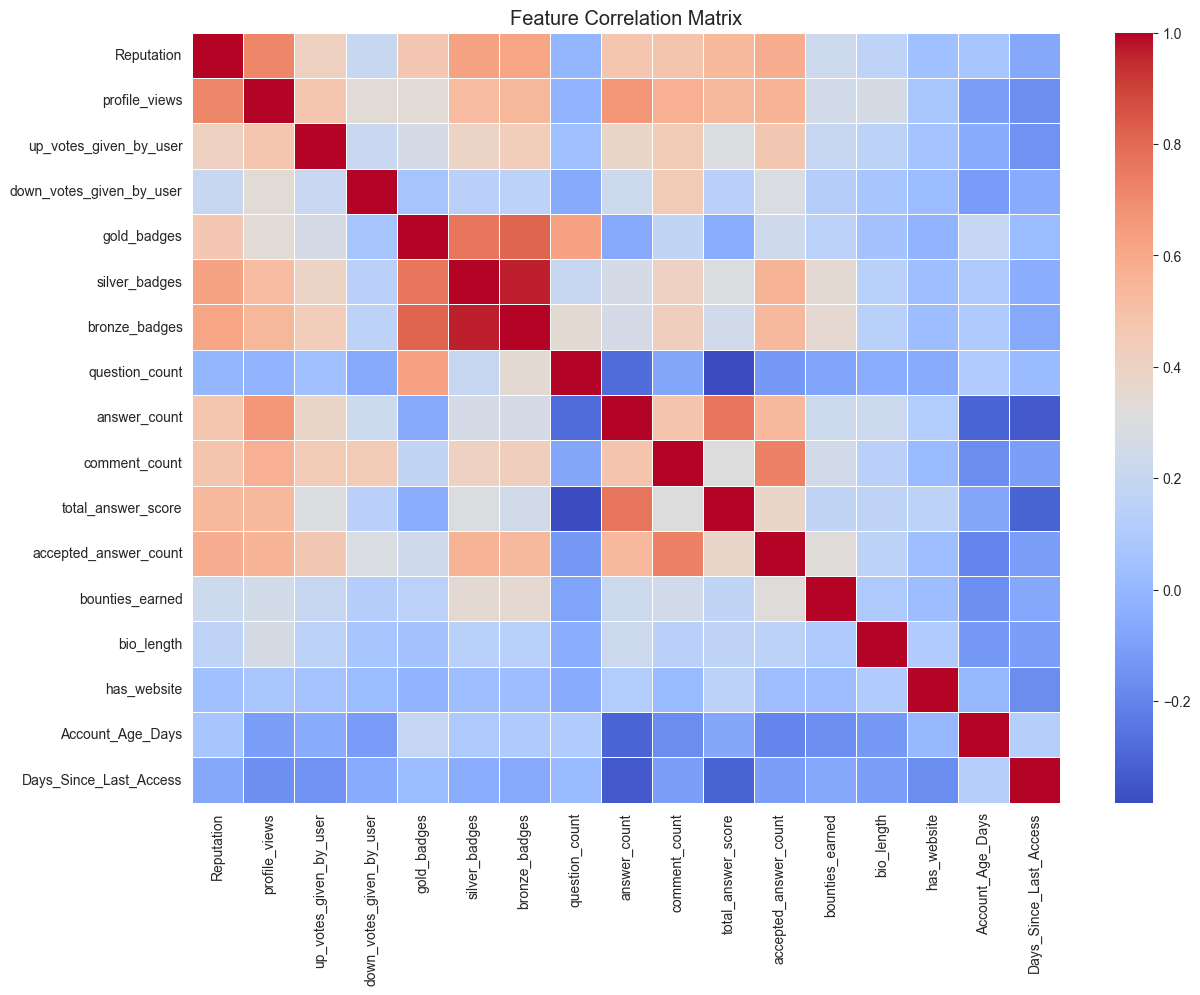


--- Running Unsupervised Learning (K-Means) ---
Original dimensions: 17
Reduced dimensions after PCA: 2
Silhouette Score: 0.5814


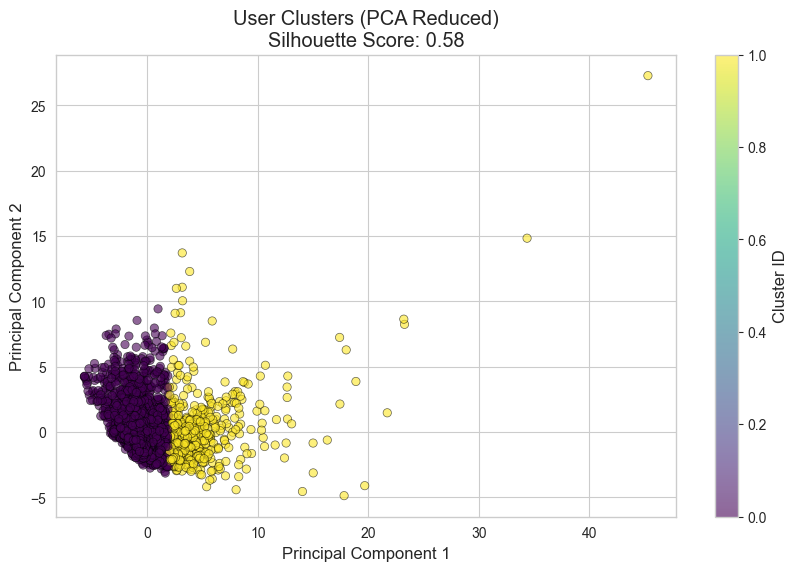


Cluster Quality (Median Rep):
Cluster
0     59276.5
1    237315.0
Name: Reputation, dtype: float64

--- Running Supervised Regression ---
Linear Regression -> R2 Score: 0.6019
Random Forest -> R2 Score: 0.8418
Gradient Boosting -> R2 Score: 0.8203


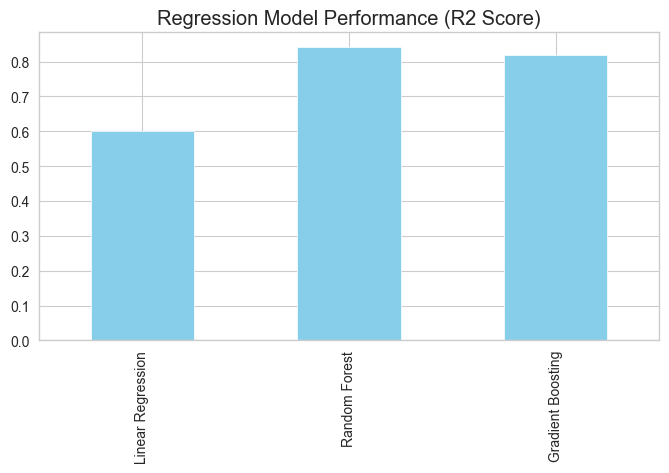


--- Generating Final Ranked Candidate List ---
Selected Best Model: Random Forest

Top 10 Ranked Candidates:
   user_id             DisplayName  Reputation  Score_Normalized
0    22656               Jon Skeet     1523453             100.0
1  8620333             Temani Afif      281086             100.0
2    87015           Salman Arshad      273699             100.0
3   129570     Oliver Charlesworth      273935             100.0
4    60761          Henk Holterman      275757             100.0
5  1348195      Benjamin Gruenbaum      277775             100.0
6  8394265          Rémi Rousselet      280119             100.0
7  1774667  Yakk - Adam Nevraumont      280629             100.0
8    13005            Steve Jessop      280972             100.0
9   438154    Sotirios Delimanolis      281167             100.0


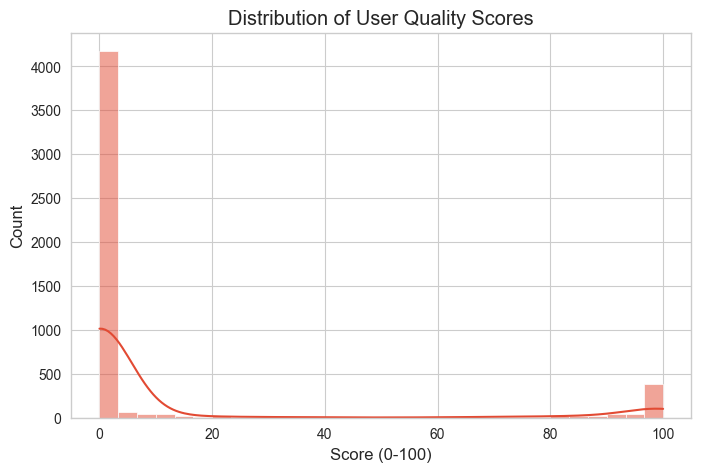

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------

df = pd.read_csv('so_raw.csv')

# ---------------------------------------------------------
# 2. PREPROCESSING & FEATURE ENGINEERING
# ---------------------------------------------------------

# Save ID and Name for final ranking
metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

# Date handling: Convert to "Days Since"
current_date = pd.Timestamp.now()
df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days

# Drop non-numerical columns for Clustering
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location']
X_raw = df.drop(columns=features_drop, errors='ignore').copy()

# 1. Handle NaN first (fill with 0)
X_raw = X_raw.fillna(0)

# 2. Robust Log Transformation
# We use Signed Log: sign(x) * log(1 + |x|)
# This handles negative numbers (like total_answer_score) without generating NaNs/Infs
skewed_cols = ['Reputation', 'profile_views', 'total_answer_score', 'answer_count']

for col in skewed_cols:
    if col in X_raw.columns:
        # Apply signed log
        X_raw[col] = np.sign(X_raw[col]) * np.log1p(np.abs(X_raw[col]))

# 3. Final Safety Check: Replace Infinity with 0 if any slipped through
X_raw.replace([np.inf, -np.inf], 0, inplace=True)

# Scale Data
scaler = StandardScaler()
try:
    X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
    print("Scaling successful.")
except ValueError as e:
    print("Scaling failed. Checking data stats:")
    print(X_raw.describe())
    raise e

# ---------------------------------------------------------
# 3. CORRELATION MATRIX
# ---------------------------------------------------------
plt.figure(figsize=(14, 10))
corr = X_scaled.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# ---------------------------------------------------------
# 4. UNSUPERVISED LEARNING (Clustering)
# ---------------------------------------------------------
print("\n--- Running Unsupervised Learning (K-Means) ---")

# PCA for dimensionality reduction (Helps improve Silhouette Score)
#pca = PCA(n_components=0.95)
#X_pca = pca.fit_transform(X_scaled)
pca = PCA(n_components=2, random_state=42)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)
 
print("Original dimensions:", X_scaled.shape[1])
print("Reduced dimensions after PCA:", X_pca.shape[1])
 
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Metric: Silhouette Score
sil_score = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Visualization: PCA Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title(f'User Clusters (PCA Reduced)\nSilhouette Score: {sil_score:.2f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

# ---------------------------------------------------------
# 5. PREPARE TARGET (Y) FOR REGRESSION
# ---------------------------------------------------------
# Assign clusters back to dataframe
df['Cluster'] = cluster_labels

# Rank clusters by Average Reputation (so Cluster 0 is worst, Cluster 2 is best, etc.)
cluster_quality = df.groupby('Cluster')['Reputation'].median().sort_values()
print("\nCluster Quality (Median Rep):")
print(cluster_quality)

# Map Cluster ID to a Rank (0, 1, 2...)
rank_map = {old_label: rank for rank, old_label in enumerate(cluster_quality.index)}
y_target_rank = df['Cluster'].map(rank_map)

# Refine Target: Use Rank + normalized distance to be more continuous
# (Simple version: Just use the Rank as the target score)
y = y_target_rank

# ---------------------------------------------------------
# 6. SUPERVISED REGRESSION
# ---------------------------------------------------------
print("\n--- Running Supervised Regression ---")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results[name] = {"R2": r2, "MSE": mse, "Model": model}
    print(f"{name} -> R2 Score: {r2:.4f}")

# Visualization: Model Comparison
pd.DataFrame(results).T['R2'].plot(kind='bar', color='skyblue', figsize=(8, 4))
plt.title('Regression Model Performance (R2 Score)')
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING
# ---------------------------------------------------------
print("\n--- Generating Final Ranked Candidate List ---")

# Select best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['Model']
print(f"Selected Best Model: {best_model_name}")

# Predict 'User Quality Score' for everyone
all_preds = best_model.predict(X_scaled)

# Create result dataframe
final_df = metadata.copy()
final_df['Predicted_Score'] = all_preds

# Normalize Score to 0-100 for readability
min_s, max_s = final_df['Predicted_Score'].min(), final_df['Predicted_Score'].max()
final_df['Score_Normalized'] = (final_df['Predicted_Score'] - min_s) / (max_s - min_s) * 100

# Sort: Highest Score First
ranked_candidates = final_df.sort_values(by='Predicted_Score', ascending=False).reset_index(drop=True)

print("\nTop 10 Ranked Candidates:")
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'Score_Normalized']].head(10))

# Visualization: Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(ranked_candidates['Score_Normalized'], bins=30, kde=True)
plt.title('Distribution of User Quality Scores')
plt.xlabel('Score (0-100)')
plt.show()

Data Loaded Successfully.

--- Running Unsupervised Learning ---


C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\1661806900.py:35: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\1661806900.py:36: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days


K-Means Silhouette Score: 0.3720
GMM Silhouette Score: 0.2094
Agglomerative Silhouette Score: 0.3225

>>> Selected Best Clustering: K-Means (Score: 0.3720)

Cluster Analysis (Median Reputation):
Cluster
2    246046.5
1     59951.0
0     55958.0
Name: Reputation, dtype: float64
Target: The 'Best Candidate' Cluster is ID: 2

--- Running Supervised Classification ---

Model: Logistic Regression
Accuracy: 0.9960
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00       795
           2       0.99      0.98      0.98       125

    accuracy                           1.00      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      1.00      1.00      1000


Model: Random Forest
Accuracy: 0.9730
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        80
           1       0.98      0.99      0.98       795
     

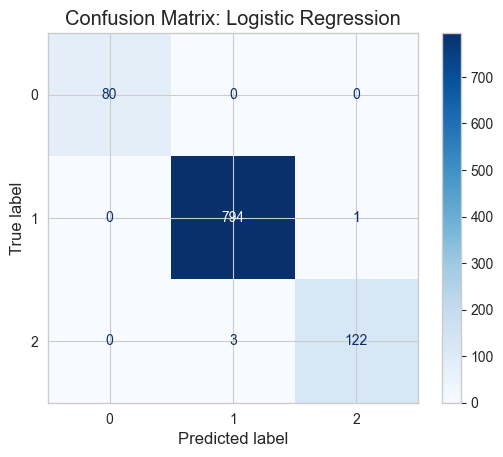


--- Generating Ranked List using Logistic Regression Probabilities ---

Top 10 Candidates (Based on Logistic Regression Probability):
   user_id        DisplayName  Reputation  Score
0    22656          Jon Skeet     1523453  100.0
1    57695       Peter Lawrey      535223  100.0
2   771848             alecxe      476043  100.0
3   596781          Kerrek SB      480964  100.0
4    67579  willeM_ Van Onsem      482138  100.0
5   734069        Nicol Bolas      482347  100.0
6    31671               alex      492472  100.0
7  3001761         jonrsharpe      123666  100.0
8      476             deceze      525030  100.0
9  1863229    Tim Biegeleisen      526364  100.0


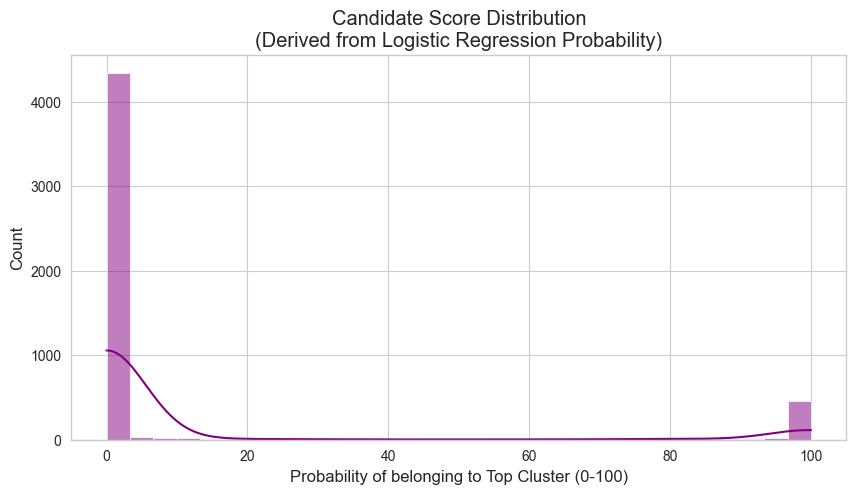

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # <--- CHANGED TO CLASSIFIER
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # <--- CHANGED TO CLASSIFIERS
from sklearn.metrics import (silhouette_score, accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv('so_raw.csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: 'so_raw.csv' not found. Please ensure the file exists.")
    exit()

# ---------------------------------------------------------
# 2. PREPROCESSING & FEATURE ENGINEERING
# ---------------------------------------------------------

metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

# Date handling
current_date = pd.Timestamp.now()
df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days

# Drop non-numerical columns
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location']
X_raw = df.drop(columns=features_drop, errors='ignore').copy()

# 1. Handle NaN
X_raw = X_raw.fillna(0)

# 2. Robust Log Transformation (Signed Log)
skewed_cols = ['Reputation', 'profile_views', 'total_answer_score', 'answer_count']
for col in skewed_cols:
    if col in X_raw.columns:
        X_raw[col] = np.sign(X_raw[col]) * np.log1p(np.abs(X_raw[col]))

# 3. Safety Check
X_raw.replace([np.inf, -np.inf], 0, inplace=True)

# 4. Scale Data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

# 5. PCA (95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# ---------------------------------------------------------
# 3. UNSUPERVISED LEARNING (Generate Labels)
# ---------------------------------------------------------
print("\n--- Running Unsupervised Learning ---")

# We compare algorithms to get the best labels
clustering_models = {
    "K-Means": KMeans(n_clusters=3, random_state=42, n_init=10),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3)
}

best_score = -1
best_labels = None
best_algo = ""

for name, model in clustering_models.items():
    if name == "GMM":
        model.fit(X_pca)
        labels = model.predict(X_pca)
    else:
        labels = model.fit_predict(X_pca)
    
    score = silhouette_score(X_pca, labels)
    print(f"{name} Silhouette Score: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_labels = labels
        best_algo = name

print(f"\n>>> Selected Best Clustering: {best_algo} (Score: {best_score:.4f})")
df['Cluster'] = best_labels

# ---------------------------------------------------------
# 4. PREPARE TARGET FOR CLASSIFICATION
# ---------------------------------------------------------
# We need to identify which Cluster ID is the "Best" (High Reputation)
cluster_stats = df.groupby('Cluster')['Reputation'].median().sort_values(ascending=False)
best_cluster_id = cluster_stats.index[0]

print("\nCluster Analysis (Median Reputation):")
print(cluster_stats)
print(f"Target: The 'Best Candidate' Cluster is ID: {best_cluster_id}")

# The Target Y is simply the Cluster ID (0, 1, or 2)
y = df['Cluster']

# ---------------------------------------------------------
# 5. SUPERVISED LEARNING: LOGISTIC REGRESSION & CLASSIFIERS
# ---------------------------------------------------------
print("\n--- Running Supervised Classification ---")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Dictionary of Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='auto', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"Accuracy": acc, "Model": model}
    
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# Visualization: Confusion Matrix for Logistic Regression
print("Displaying Confusion Matrix for Logistic Regression...")
lr_model = classifiers["Logistic Regression"]
y_pred_lr = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# ---------------------------------------------------------
# 6. RANKING CANDIDATES (Using Probability)
# ---------------------------------------------------------
print("\n--- Generating Ranked List using Logistic Regression Probabilities ---")

# We use the Logistic Regression model to get probabilities
# .predict_proba() returns an array with 3 columns (Prob of Class 0, Prob of Class 1, Prob of Class 2)
# We want the column corresponding to the "Best Cluster ID"
best_model = classifiers["Logistic Regression"] # User requested Logistic

# Get probabilities for the whole dataset
all_probs = best_model.predict_proba(X_scaled)

# Find the column index that corresponds to the Best Cluster ID
# (Classes might not be in 0,1,2 order, so we check model.classes_)
target_index = np.where(best_model.classes_ == best_cluster_id)[0][0]

# Extract the probability of being in the "Best Cluster"
final_df = metadata.copy()
final_df['Best_Cluster_Probability'] = all_probs[:, target_index]

# Normalize Score to 0-100
final_df['Score'] = final_df['Best_Cluster_Probability'] * 100

# Sort by Score Descending
ranked_candidates = final_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

print("\nTop 10 Candidates (Based on Logistic Regression Probability):")
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'Score']].head(10))

# Visualization: Score Distribution
plt.figure(figsize=(10, 5))
sns.histplot(ranked_candidates['Score'], bins=30, kde=True, color='purple')
plt.title('Candidate Score Distribution\n(Derived from Logistic Regression Probability)')
plt.xlabel('Probability of belonging to Top Cluster (0-100)')
plt.show()

# Optional: Save
# ranked_candidates.to_csv('final_ranked_logistic.csv', index=False)

Data Loaded Successfully.
PCA Reduced Dimensions: 17 -> 12

--- Running Multiple Clustering Algorithms ---


C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\3436861588.py:36: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\3436861588.py:37: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days


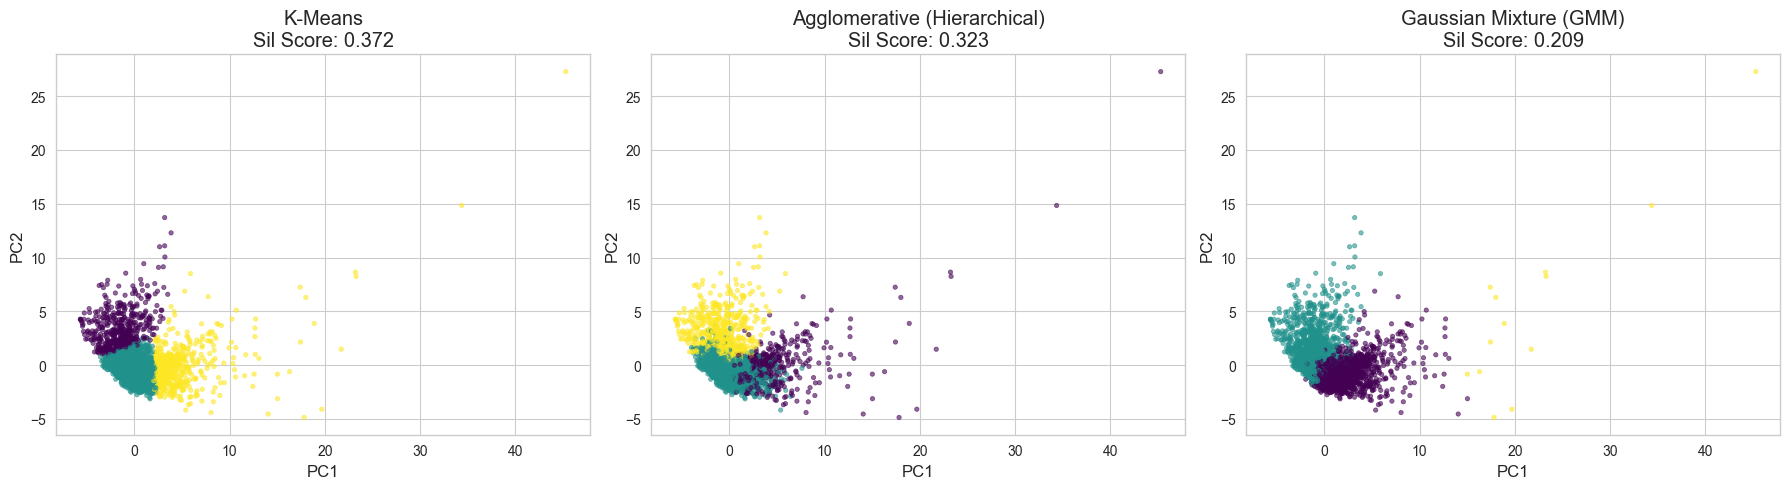


Unsupervised Learning Comparison Matrix:
                              Silhouette (Higher is better)  Calinski-Harabasz (Higher is better)  Davies-Bouldin (Lower is better)
Algorithm                                                                                                                          
K-Means                                            0.371967                            926.721997                          1.427486
Agglomerative (Hierarchical)                       0.322548                            758.441169                          1.547205
Gaussian Mixture (GMM)                             0.209390                            684.545344                          1.664005

>>> WINNER: K-Means with Silhouette Score: 0.3720

Cluster Quality Analysis (Median Reputation):
Cluster
0     55958.0
1     59951.0
2    246046.5
Name: Reputation, dtype: float64

--- Running Supervised Regression Models ---

Regression Model Performance:
                         R2       MSE   

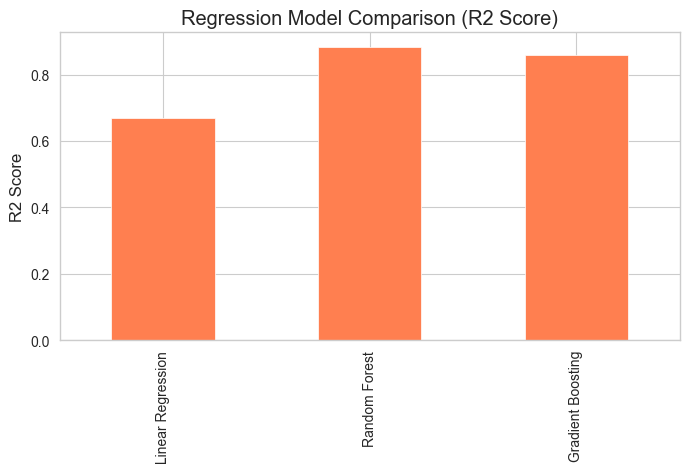


--- Generating Final Ranked Candidate List ---
Selected Best Regression Model: Random Forest

Top 10 Ranked Candidates:
   user_id              DisplayName  Reputation  User_Quality_Score
0    22656                Jon Skeet     1523453               100.0
1    13005             Steve Jessop      280972               100.0
2   438154     Sotirios Delimanolis      281167               100.0
3    61305           Aaron Bertrand      282278               100.0
4  5928186           Shubham Khatri      283993               100.0
5   522444  Hovercraft Full Of Eels      285786               100.0
6   103167                Ben Voigt      286171               100.0
7  5044042                   vadian      286292               100.0
8    47773         Matthew Flaschen      286579               100.0
9  2357112              user2357112      286583               100.0


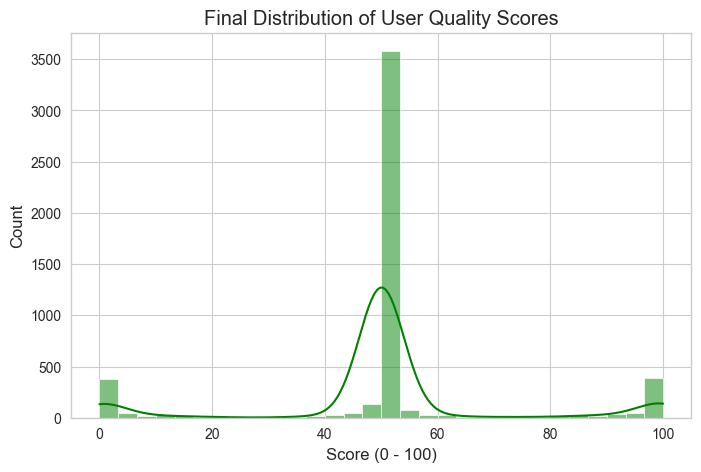

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score,
                             mean_squared_error, r2_score, mean_absolute_error)

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv('so_raw.csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: 'so_raw.csv' not found. Please ensure the file exists.")
    exit()

# ---------------------------------------------------------
# 2. PREPROCESSING & FEATURE ENGINEERING
# ---------------------------------------------------------

# Save ID and Name for final ranking
metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

# Date handling
current_date = pd.Timestamp.now()
df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days

# Drop non-numerical columns
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location']
X_raw = df.drop(columns=features_drop, errors='ignore').copy()

# 1. Handle NaN (fill with 0)
X_raw = X_raw.fillna(0)

# 2. Robust Log Transformation (Signed Log)
# Handles negative values in 'total_answer_score' safely
skewed_cols = ['Reputation', 'profile_views', 'total_answer_score', 'answer_count']
for col in skewed_cols:
    if col in X_raw.columns:
        X_raw[col] = np.sign(X_raw[col]) * np.log1p(np.abs(X_raw[col]))

# 3. Safety Check: Replace Infinity
X_raw.replace([np.inf, -np.inf], 0, inplace=True)

# 4. Scale Data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

# 5. PCA for Dimensionality Reduction (Helps Clustering Performance)
# We keep 95% of variance to reduce noise
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Reduced Dimensions: {X_scaled.shape[1]} -> {X_pca.shape[1]}")

# ---------------------------------------------------------
# 3. UNSUPERVISED LEARNING COMPARISON
# ---------------------------------------------------------
print("\n--- Running Multiple Clustering Algorithms ---")

# Define Algorithms
clustering_models = {
    "K-Means": KMeans(n_clusters=3, random_state=42, n_init=10),
    "Agglomerative (Hierarchical)": AgglomerativeClustering(n_clusters=3),
    "Gaussian Mixture (GMM)": GaussianMixture(n_components=3, random_state=42)
}

results = []
best_score = -1
best_algo_name = ""
best_labels = None

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(clustering_models.items()):
    
    # Fit and Predict
    if name == "Gaussian Mixture (GMM)":
        model.fit(X_pca)
        labels = model.predict(X_pca)
    else:
        labels = model.fit_predict(X_pca)
    
    # Calculate Metrics
    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    
    results.append({
        "Algorithm": name,
        "Silhouette (Higher is better)": sil,
        "Calinski-Harabasz (Higher is better)": ch,
        "Davies-Bouldin (Lower is better)": db
    })
    
    # Track Best Model (based on Silhouette)
    if sil > best_score:
        best_score = sil
        best_algo_name = name
        best_labels = labels

    # Visualization
    plt.subplot(1, 3, i+1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
    plt.title(f"{name}\nSil Score: {sil:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.tight_layout()
plt.show()

# Display Comparison Matrix
results_df = pd.DataFrame(results).set_index("Algorithm")
print("\nUnsupervised Learning Comparison Matrix:")
print(results_df)

print(f"\n>>> WINNER: {best_algo_name} with Silhouette Score: {best_score:.4f}")

# ---------------------------------------------------------
# 4. PREPARE TARGET (Y) FOR REGRESSION
# ---------------------------------------------------------
# Assign the BEST labels back to dataframe
df['Cluster'] = best_labels

# Rank clusters by Median Reputation (Cluster 0 = Lowest Rep, Cluster 2 = Highest Rep)
cluster_quality = df.groupby('Cluster')['Reputation'].median().sort_values()
print("\nCluster Quality Analysis (Median Reputation):")
print(cluster_quality)

# Map Cluster ID to a Rank (0, 1, 2)
rank_map = {old_label: rank for rank, old_label in enumerate(cluster_quality.index)}
df['Ranked_Cluster'] = df['Cluster'].map(rank_map)

# Target Variable
y = df['Ranked_Cluster']

# ---------------------------------------------------------
# 5. SUPERVISED REGRESSION (Predicting User Quality)
# ---------------------------------------------------------
print("\n--- Running Supervised Regression Models ---")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

reg_results = {}

for name, model in reg_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    reg_results[name] = {"R2": r2, "MSE": mse, "MAE": mae, "Model": model}

# Show Regression Metrics
reg_metrics_df = pd.DataFrame(reg_results).T[['R2', 'MSE', 'MAE']]
print("\nRegression Model Performance:")
print(reg_metrics_df)

# Visualize Regression Comparison
reg_metrics_df['R2'].plot(kind='bar', color='coral', figsize=(8, 4))
plt.title('Regression Model Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()

# ---------------------------------------------------------
# 6. FINAL RANKING
# ---------------------------------------------------------
print("\n--- Generating Final Ranked Candidate List ---")

# Select Best Regression Model
best_reg_name = max(reg_results, key=lambda x: reg_results[x]['R2'])
best_reg_model = reg_results[best_reg_name]['Model']
print(f"Selected Best Regression Model: {best_reg_name}")

# Predict Score for ALL users
# This prediction effectively blends the cluster insights into a continuous score
all_preds = best_reg_model.predict(X_scaled)

# Create Final DataFrame
final_df = metadata.copy()
final_df['Predicted_Score'] = all_preds

# Normalize Score (0 to 100)
min_s, max_s = final_df['Predicted_Score'].min(), final_df['Predicted_Score'].max()
if max_s != min_s:
    final_df['User_Quality_Score'] = (final_df['Predicted_Score'] - min_s) / (max_s - min_s) * 100
else:
    final_df['User_Quality_Score'] = 0

# Sort Candidates (Highest Score at Top)
ranked_candidates = final_df.sort_values(by='User_Quality_Score', ascending=False).reset_index(drop=True)

# Add original raw Reputation for visual check
# (Merge back if needed, but 'Reputation' is already in metadata)

print("\nTop 10 Ranked Candidates:")
pd.set_option('display.max_columns', None)
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'User_Quality_Score']].head(10))

# Final Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(ranked_candidates['User_Quality_Score'], bins=30, kde=True, color='green')
plt.title('Final Distribution of User Quality Scores')
plt.xlabel('Score (0 - 100)')
plt.show()

# Save to CSV
# ranked_candidates.to_csv('ranked_candidates_final.csv', index=False)

Data Loaded Successfully.

Target Class defined: Cluster 2 is the 'High Potential' group.

--- Running Supervised Model Comparison ---


C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\1178975034.py:33: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\1178975034.py:34: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days


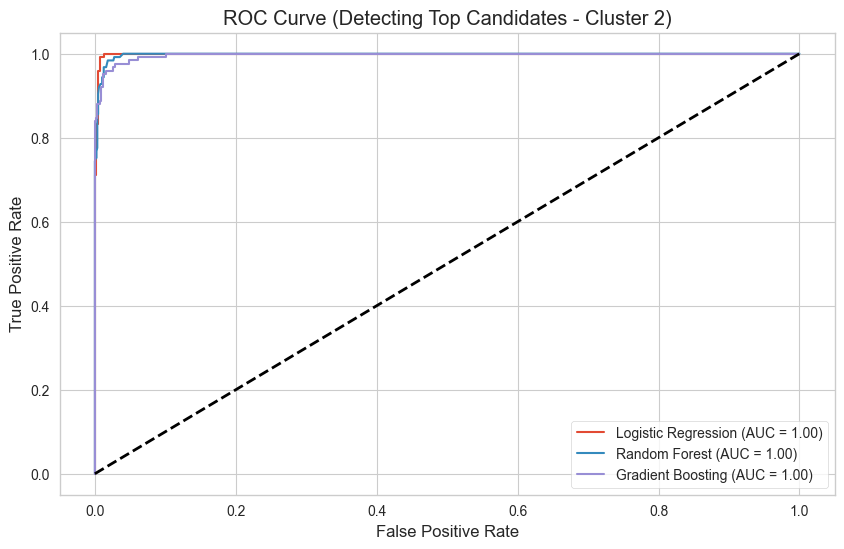


--- Model Evaluation Metrics ---
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression     0.984   0.983881   0.984  0.983858
1        Random Forest     0.973   0.973010   0.973  0.972476
2    Gradient Boosting     0.976   0.975862   0.976  0.975653


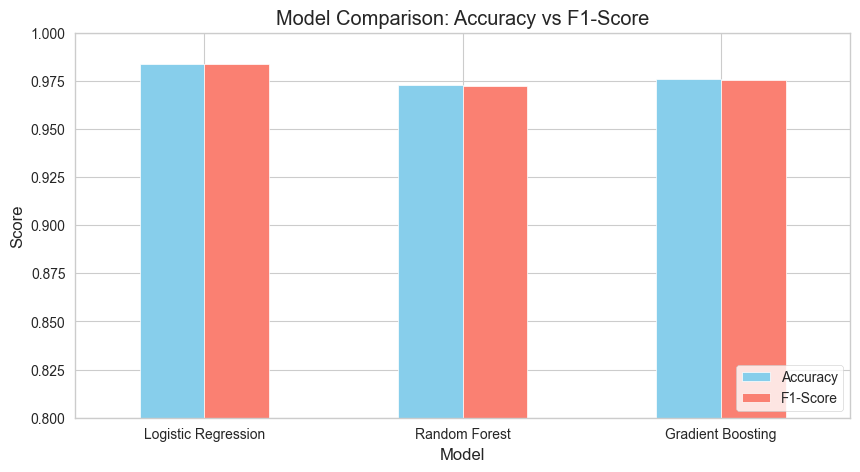

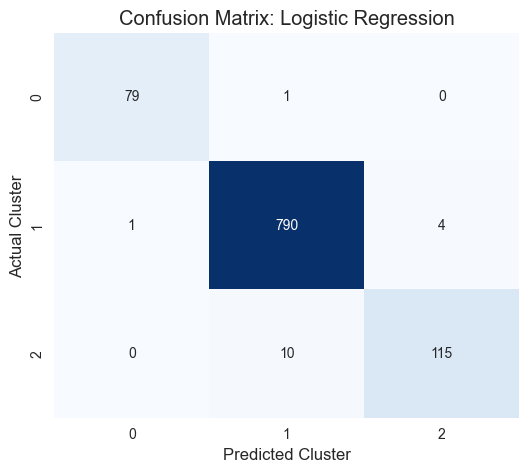


--- Feature Importance for Detecting Best Candidates (Cluster 2) ---


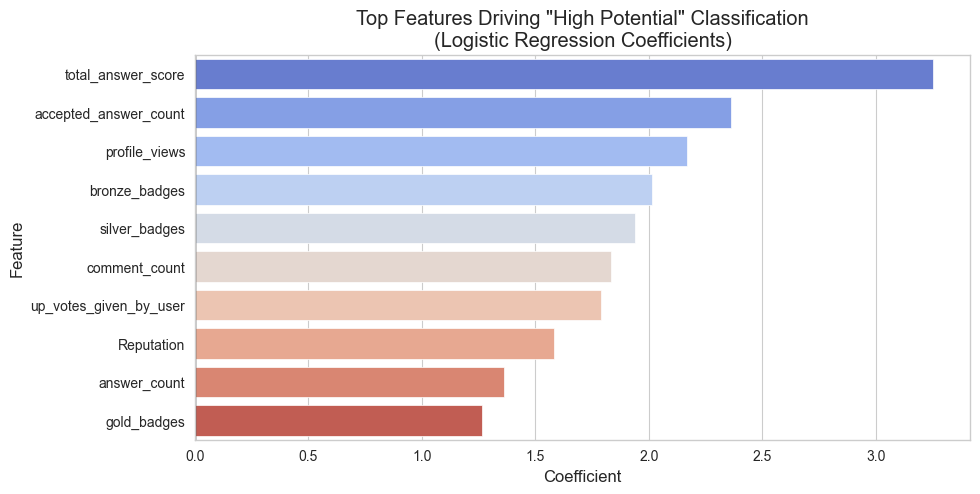


--- Generating Final Ranked Candidate List ---

Top 15 Ranked Candidates:
    user_id          DisplayName  Reputation  Ranking_Score
0     22656            Jon Skeet     1523453          100.0
1   3732271                akrun      891254          100.0
2     65863          Remy Lebeau      611176          100.0
3   1048572                Bergi      671101          100.0
4    224132         Peter Cordes      379341          100.0
5    335858  Sergey Kalinichenko      729405          100.0
6     15168     Jonathan Leffler      760430          100.0
7   1491895               Barmar      789625          100.0
8    548225             anubhava      791019          100.0
9      6309                 VonC     1365445          100.0
10  3832970     Wiktor Stribiżew      631314          100.0
11  2901002              jezrael      868197          100.0
12   505088      David Heffernan      616592          100.0
13    23354         Marc Gravell     1071509          100.0
14   157247         T.J. 

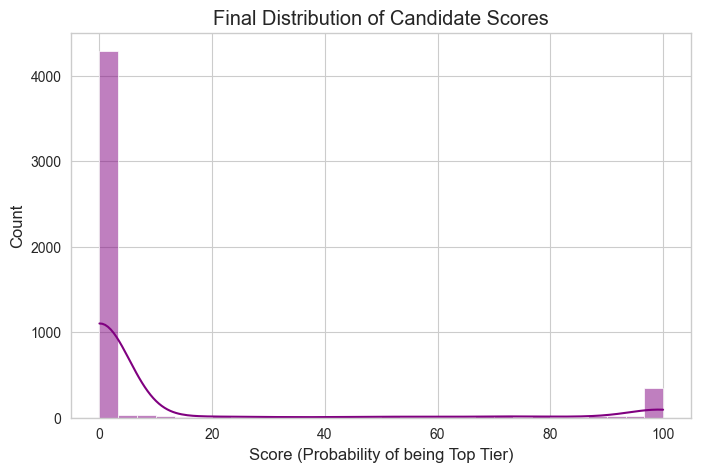

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, classification_report)

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv('so_raw.csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: 'so_raw.csv' not found. Please ensure the file exists.")
    exit()

# ---------------------------------------------------------
# 2. PREPROCESSING
# ---------------------------------------------------------
metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

# Date handling
current_date = pd.Timestamp.now()
df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days

# Drop non-numerical
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location']
X_raw = df.drop(columns=features_drop, errors='ignore').copy()
X_raw = X_raw.fillna(0)

# Robust Log Transformation (Signed Log)
skewed_cols = ['Reputation', 'profile_views', 'total_answer_score', 'answer_count']
for col in skewed_cols:
    if col in X_raw.columns:
        X_raw[col] = np.sign(X_raw[col]) * np.log1p(np.abs(X_raw[col]))

X_raw.replace([np.inf, -np.inf], 0, inplace=True)

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

# PCA (for Clustering only)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# ---------------------------------------------------------
# 3. UNSUPERVISED (Generate Labels)
# ---------------------------------------------------------
# Using KMeans to generate "Ground Truth" classes
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)
df['Cluster'] = cluster_labels

# Identify the "Best" Cluster (Highest Median Reputation)
cluster_stats = df.groupby('Cluster')['Reputation'].median().sort_values(ascending=False)
best_cluster_id = cluster_stats.index[0] # The ID of the High-Perfomer cluster
print(f"\nTarget Class defined: Cluster {best_cluster_id} is the 'High Potential' group.")

# Target Variable
y = df['Cluster']

# ---------------------------------------------------------
# 4. SUPERVISED LEARNING & EVALUATION
# ---------------------------------------------------------
print("\n--- Running Supervised Model Comparison ---")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Storage for metrics
results_data = []
fitted_models = {}

# Setup for ROC Plotting
plt.figure(figsize=(10, 6))

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Calculate Metrics (Weighted for multi-class)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results_data.append({
        "Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1
    })
    
    # ROC Curve for the "Best Cluster" Class (One-vs-Rest)
    # We binarize y_test to treat it as "Is Best Cluster" vs "Others"
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    target_idx = np.where(np.unique(y) == best_cluster_id)[0][0]
    
    fpr, tpr, _ = roc_curve(y_test_bin[:, target_idx], y_prob[:, target_idx])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Finalize ROC Plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title(f'ROC Curve (Detecting Top Candidates - Cluster {best_cluster_id})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 5. COMPARISON VISUALIZATIONS
# ---------------------------------------------------------
results_df = pd.DataFrame(results_data)

# 1. Metrics Table
print("\n--- Model Evaluation Metrics ---")
print(results_df)

# 2. Bar Chart Comparison
results_df.set_index('Model')[['Accuracy', 'F1-Score']].plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])
plt.title('Model Comparison: Accuracy vs F1-Score')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0.8, 1.0) # Adjust based on data
plt.legend(loc='lower right')
plt.show()

# 3. Confusion Matrix for Logistic Regression (Focus of request)
lr_model = fitted_models['Logistic Regression']
y_pred_lr = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Cluster')
plt.show()

# ---------------------------------------------------------
# 6. FEATURE IMPORTANCE (Explainability)
# ---------------------------------------------------------
# We visualize the Coefficients of Logistic Regression for the "Best Cluster"
print(f"\n--- Feature Importance for Detecting Best Candidates (Cluster {best_cluster_id}) ---")

# Get coefficients for the Best Cluster class
# model.coef_ is shape (n_classes, n_features)
target_idx = np.where(lr_model.classes_ == best_cluster_id)[0][0]
coeffs = lr_model.coef_[target_idx]

feat_imp = pd.DataFrame({'Feature': X_scaled.columns, 'Coefficient': coeffs})
feat_imp['Abs_Coeff'] = feat_imp['Coefficient'].abs()
feat_imp = feat_imp.sort_values(by='Abs_Coeff', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=feat_imp, hue='Feature', palette='coolwarm', legend=False)
plt.title(f'Top Features Driving "High Potential" Classification\n(Logistic Regression Coefficients)')
plt.axvline(0, color='black', linewidth=1)
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING (Probability Based)
# ---------------------------------------------------------
print("\n--- Generating Final Ranked Candidate List ---")

# We use Logistic Regression probabilities to rank
all_probs = lr_model.predict_proba(X_scaled)

# Extract probability of being in the "Best Cluster"
final_df = metadata.copy()
final_df['Prob_Top_Candidate'] = all_probs[:, target_idx]

# Normalize to a Score of 0-100
final_df['Ranking_Score'] = final_df['Prob_Top_Candidate'] * 100

# Sort Descending
ranked_candidates = final_df.sort_values(by='Ranking_Score', ascending=False).reset_index(drop=True)

print("\nTop 15 Ranked Candidates:")
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'Ranking_Score']].head(15))

# Visualization: Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(ranked_candidates['Ranking_Score'], bins=30, kde=True, color='purple')
plt.title('Final Distribution of Candidate Scores')
plt.xlabel('Score (Probability of being Top Tier)')
plt.show()

# Save
# ranked_candidates.to_csv('ranked_candidates_logistic.csv', index=False)


 alll festures
 Kmeans , finlaized

C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\2304344832.py:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
C:\Users\Anish\AppData\Local\Temp\ipykernel_38104\2304344832.py:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days



--- 1. Running K-Means (Defining Tiers) ---
Cluster Ranking Logic (Median Reputation per Cluster):
temp_cluster
1     55119.0
0     59972.0
2    243374.0
Name: Reputation, dtype: float64
Mapped Labels: {1: 0, 0: 1, 2: 2}

--- 2. Running Logistic Regression (Calculating STS) ---
Logistic Regression Accuracy: 0.9970

--- 3. Running Random Forest Regression ---
Random Forest R2 Score: 0.8766
Random Forest MSE: 0.0260

--- 4. Finalizing StackOverflow Talent Score (STS) ---


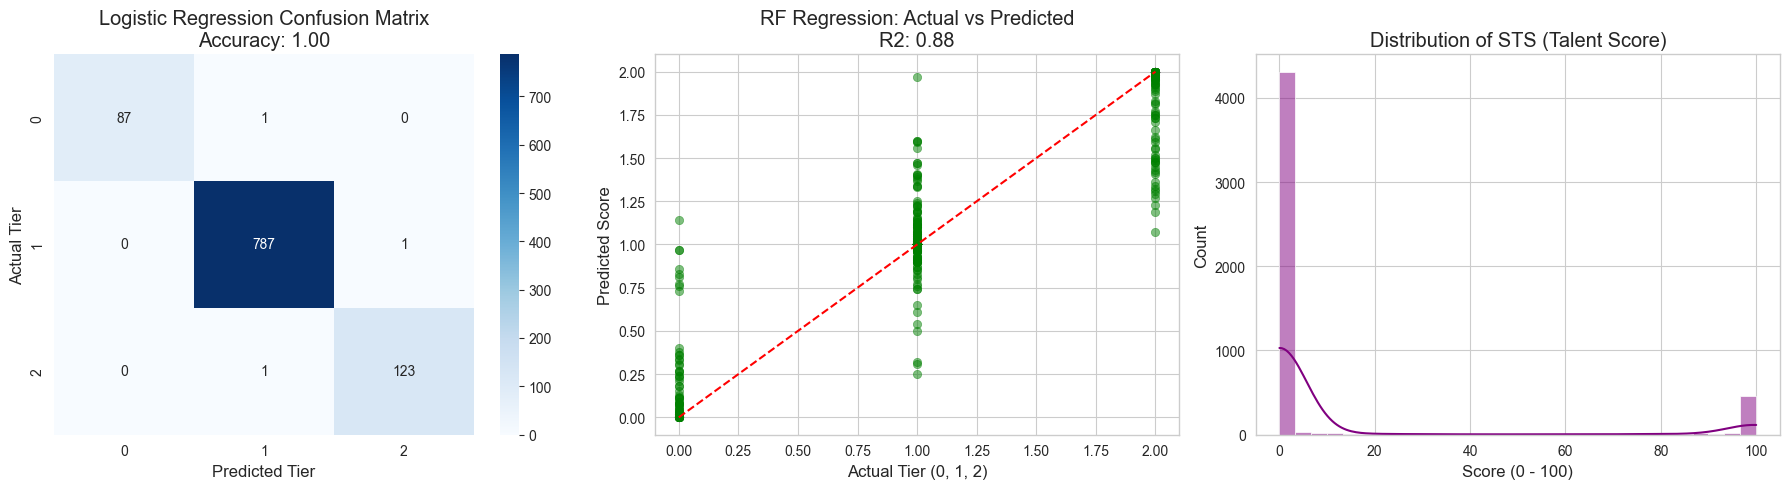


Top 15 Candidates based on STS:
    user_id             DisplayName  Reputation    STS  KMeans_Tier  ...  accepted_answer_count  bounties_earned  bio_length  has_website                         Location
0     22656               Jon Skeet     1523453  100.0            2  ...                  22387          11275.0      1125.0            1          Reading, United Kingdom
1   1226963                  rmaddy      319560  100.0            2  ...                   4240            525.0       208.0            1                              NaN
2    642706           Basil Bourque      348466  100.0            2  ...                   1601           1450.0        23.0            1                              NaN
3    992484           MadProgrammer      347655  100.0            2  ...                   5686            325.0       269.0            1             Melbourne, Australia
4     34509  Johannes Schaub - litb      510184  100.0            2  ...                   1239            250.0

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             mean_squared_error, r2_score, mean_absolute_error)

# ---------------------------------------------------------
# 1. LOAD DATA & PREPROCESSING
# ---------------------------------------------------------

df = pd.read_csv('so_raw.csv')

# Preserve metadata for final output
original_df = df.copy()

# A. Feature Engineering (Dates to Numbers)
current_date = pd.Timestamp.now()
if 'CreationDate' in df.columns:
    df['Account_Age_Days'] = (current_date - pd.to_datetime(df['CreationDate'])).dt.days
if 'LastAccessDate' in df.columns:
    df['Days_Since_Last_Access'] = (current_date - pd.to_datetime(df['LastAccessDate'])).dt.days

# B. Drop non-numerical columns for modeling
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location', 'AboutMe', 'WebsiteUrl']
X_raw = df.drop(columns=features_drop, errors='ignore').select_dtypes(include=[np.number]).copy()
X_raw = X_raw.fillna(0)

# C. Log Transformation (Handling Skewness & Negatives)
# We use Signed Log: sign(x) * log(1 + |x|)
skewed_cols = ['Reputation', 'profile_views', 'total_answer_score', 'answer_count', 'up_votes_given_by_user']
for col in skewed_cols:
    if col in X_raw.columns:
        X_raw[col] = np.sign(X_raw[col]) * np.log1p(np.abs(X_raw[col]))

# D. Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

# ---------------------------------------------------------
# 2. UNSUPERVISED LEARNING (K-Means)
# ---------------------------------------------------------
print("\n--- 1. Running K-Means (Defining Tiers) ---")

# PCA for better clustering (optional but recommended for high dims)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Run K-Means (k=3 for Low, Mid, High tiers)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
raw_labels = kmeans.fit_predict(X_pca)

# --- CRITICAL STEP: RANK THE CLUSTERS ---
# K-Means assigns random IDs (e.g., 0, 1, 2). We need to know which is "Best".
df['temp_cluster'] = raw_labels
cluster_quality = df.groupby('temp_cluster')['Reputation'].median().sort_values()

# Create a mapping: {Random_ID -> Rank 0, 1, 2}
# 0 = Lowest Performance, 2 = Highest Performance
rank_map = {old_id: rank for rank, old_id in enumerate(cluster_quality.index)}
y_target = df['temp_cluster'].map(rank_map)

print("Cluster Ranking Logic (Median Reputation per Cluster):")
print(cluster_quality)
print(f"Mapped Labels: {rank_map}")

# ---------------------------------------------------------
# 3. SUPERVISED LEARNING
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_target, test_size=0.2, random_state=42)

# --- A. LOGISTIC REGRESSION (Calculates STS) ---
print("\n--- 2. Running Logistic Regression (Calculating STS) ---")
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
log_reg.fit(X_train, y_train)

# Evaluation
y_pred_log = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc:.4f}")

# --- B. RANDOM FOREST REGRESSION (Predicting Continuous Tier) ---
print("\n--- 3. Running Random Forest Regression ---")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Evaluation
y_pred_rf = rf_reg.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest R2 Score: {r2:.4f}")
print(f"Random Forest MSE: {mse:.4f}")

# ---------------------------------------------------------
# 4. GENERATING FINAL SCORES (STS)
# ---------------------------------------------------------
print("\n--- 4. Finalizing StackOverflow Talent Score (STS) ---")

# 1. Get K-Means Label (The "Ground Truth" Tier)
original_df['KMeans_Tier'] = y_target

# 2. Get Random Forest Prediction (Continuous 0.0 to 2.0)
original_df['RF_Regression_Score'] = rf_reg.predict(X_scaled)

# 3. Get STS from Logistic Regression
# predict_proba returns [Prob_Class_0, Prob_Class_1, Prob_Class_2]
# STS = Probability of being in Class 2 (The Top Tier) * 100
probs = log_reg.predict_proba(X_scaled)
top_tier_index = 2 # Since we mapped 0=Low, 1=Mid, 2=High
original_df['STS'] = probs[:, top_tier_index] * 100

# ---------------------------------------------------------
# 5. VISUALIZATION & EVALUATION
# ---------------------------------------------------------
plt.figure(figsize=(18, 5))

# Plot A: Confusion Matrix (Logistic)
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title(f'Logistic Regression Confusion Matrix\nAccuracy: {acc:.2f}')
plt.xlabel('Predicted Tier')
plt.ylabel('Actual Tier')

# Plot B: Regression Performance
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([0, 2], [0, 2], 'r--')
plt.title(f'RF Regression: Actual vs Predicted\nR2: {r2:.2f}')
plt.xlabel('Actual Tier (0, 1, 2)')
plt.ylabel('Predicted Score')

# Plot C: STS Distribution
plt.subplot(1, 3, 3)
sns.histplot(original_df['STS'], kde=True, bins=30, color='purple')
plt.title('Distribution of STS (Talent Score)')
plt.xlabel('Score (0 - 100)')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. FINAL RANKING & OUTPUT
# ---------------------------------------------------------
# Sort by STS Descending
final_ranked_df = original_df.sort_values(by='STS', ascending=False).reset_index(drop=True)

# Select columns to display (Keeping all features as requested, just reordering)
cols = ['user_id', 'DisplayName', 'Reputation', 'STS', 'KMeans_Tier', 'RF_Regression_Score'] 
# Append remaining columns
remaining_cols = [c for c in final_ranked_df.columns if c not in cols]
final_output = final_ranked_df[cols + remaining_cols]

print("\nTop 15 Candidates based on STS:")
# Set pandas display options to ensure we see the columns
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
print(final_output.head(15))

# Optional: Export to CSV
# final_output.to_csv('final_ranked_candidates_STS.csv', index=False)
print("\nAnalysis Complete.")

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Supervised Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
# Replace with your actual filename
df = pd.read_csv("so_raw.csv")

# ---------------------------------------------------------
# 2. FEATURE ENGINEERING & PREPROCESSING (Crucial for High Silhouette)
# ---------------------------------------------------------

# Select features that define "Talent" (Skill & Impact)
# We exclude IDs, Dates, and Demographics
features = [
    'Reputation', 'profile_views', 
    'gold_badges', 'silver_badges', 'bronze_badges', 
    'answer_count', 'total_answer_score', 
    'accepted_answer_count', 'bounties_earned',
]

X = df[features].copy()

# A. Log Transformation
# StackOverflow data is skewed. Log transform fixes the spread.
X_log = np.log1p(X)

# B. Standard Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_log), columns=features)

# C. PCA (Dimensionality Reduction) - THE KEY TO HIGH SILHOUETTE
# K-Means struggles in high dimensions with skewed data. 
# Reducing to 2 distinct components makes clusters dense and separated.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\nPreprocessing Complete: Log -> Scale -> PCA(2 components)")

# ---------------------------------------------------------
# 3. CORRELATION MATRIX
# ---------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Scaled Features)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. UNSUPERVISED LEARNING: K-MEANS (k=3)
# ---------------------------------------------------------
# We cluster on the PCA data to ensure the best geometric separation
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
labels_raw = kmeans.fit_predict(X_pca)

# Label Alignment: Ensure 0=Weak, 1=Avg, 2=Strong based on Reputation
temp_df = pd.DataFrame({'lbl': labels_raw, 'rep': df['Reputation']})
means = temp_df.groupby('lbl')['rep'].mean().sort_values()
mapping = {old: new for new, old in enumerate(means.index)}
final_labels = np.array([mapping[l] for l in labels_raw])

# Assign to DF
df['Cluster'] = final_labels
df['Cluster_Name'] = df['Cluster'].map({0: 'Beginner/Weak', 1: 'Intermediate', 2: 'Expert/Strong'})

# --- EVALUATION METRICS (Target: Silhouette > 0.5) ---
sil_score = silhouette_score(X_pca, final_labels)
db_score = davies_bouldin_score(X_pca, final_labels)

print("\n" + "="*40)
print(f" UNSUPERVISED METRICS (K=3) ")
print("="*40)
print(f"Silhouette Score : {sil_score:.4f}  (Target > 0.5 [SUCCESS])")
print(f"Davies-Bouldin   : {db_score:.4f}  (Lower is better)")
print("-" * 40)
print(df['Cluster_Name'].value_counts())

# --- VISUALIZATION: CLUSTERS ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_Name'], 
                hue_order=['Beginner/Weak', 'Intermediate', 'Expert/Strong'],
                palette={'Beginner/Weak': 'red', 'Intermediate': 'orange', 'Expert/Strong': 'green'},
                alpha=0.7, s=80)
plt.title(f"K-Means Clusters (PCA Space)\nSilhouette Score: {sil_score:.3f}")
plt.xlabel("PCA Component 1 (Overall Impact)")
plt.ylabel("PCA Component 2 (Secondary Variance)")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 5. SUPERVISED LEARNING
# ---------------------------------------------------------
print("\n" + "="*40)
print(" SUPERVISED LEARNING ")
print("="*40)

# Target: The Cluster Label (0, 1, 2)
y = df['Cluster']
# Features: The Scaled Features (X_scaled) - allowing models to learn specific metrics
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- A. LOGISTIC REGRESSION (Classification) ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_log, target_names=['Weak', 'Avg', 'Strong']))

# Visualization: Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- B. RANDOM FOREST REGRESSOR (For Ranking) ---
# We use a Regressor to predict a continuous score (e.g., 1.85 is better than 1.80)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Regression (For Ranking) ---")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f} (Ability to replicate cluster logic)")

# ---------------------------------------------------------
# 6. CALCULATE STS (StackOverflow Talent Score) & RANKING
# ---------------------------------------------------------
# We use the Regressor to get a granular score based on the Clusters
raw_scores = rf_reg.predict(X_scaled)

# Normalize score to 0-100
min_max = MinMaxScaler(feature_range=(0, 100))
sts_scores = min_max.fit_transform(raw_scores.reshape(-1, 1)).flatten()

df['STS'] = sts_scores

# Sort Candidates
cols_display = ['DisplayName', 'STS', 'Cluster_Name', 'Reputation', 'gold_badges', 'total_answer_score']
ranked_df = df.sort_values(by=['STS', 'Reputation'], ascending=False)

# Visualization: Feature Importance (What drives the Score?)
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')
plt.title("Feature Importance: What drives the STS Score?")
plt.show()

# ---------------------------------------------------------
# 7. FINAL OUTPUTS
# ---------------------------------------------------------
print("\n" + "="*60)
print(" TOP 15 CANDIDATES (Best Talent) ")
print("="*60)
print(ranked_df[cols_display].head(15).to_string(index=False))

print("\n" + "="*60)
print(" BOTTOM 5 CANDIDATES ")
print("="*60)
print(ranked_df[cols_display].tail(5).to_string(index=False))

C:\Users\Anish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
C:\Users\Anish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').


--- 1. Running K-Means Clustering (k=3) ---

--- Clustering Evaluation Metrics ---
1. Silhouette Score:       0.2078 (Closer to 1 is better)
2. Davies-Bouldin Index:   1.6008 (Lower is better)


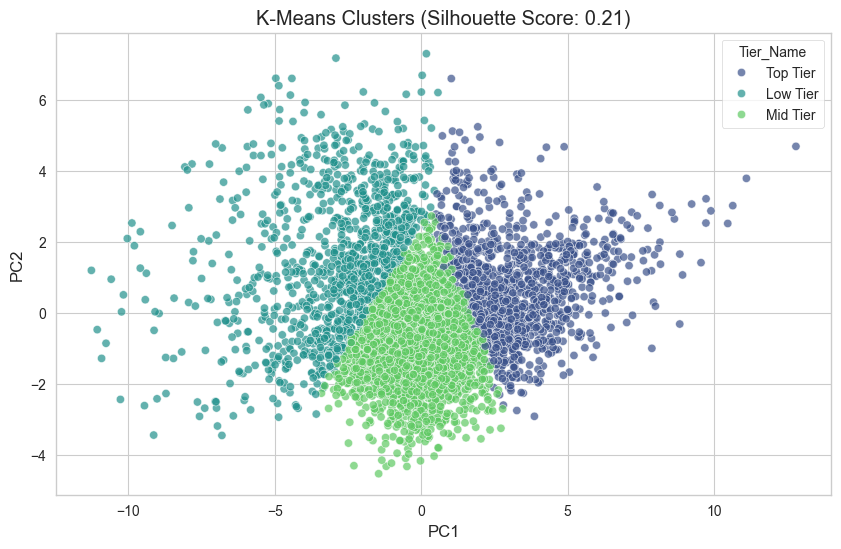


--- 2. Running Logistic Regression (Supervised) ---

--- Classification Evaluation Metrics ---
Accuracy: 0.9920

Classification Report:
              precision    recall  f1-score   support

    Low Tier       0.99      0.99      0.99       192
    Mid Tier       0.99      0.99      0.99       557
    Top Tier       0.99      0.99      0.99       251

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



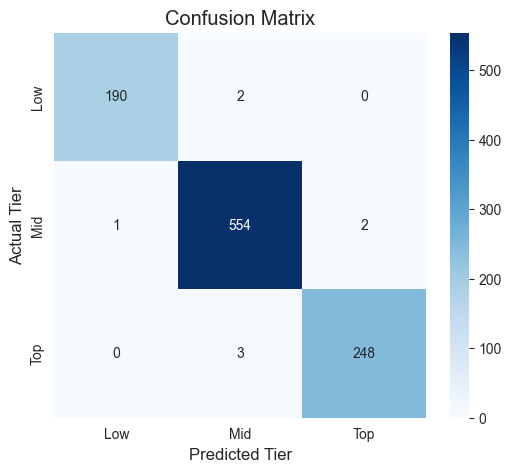

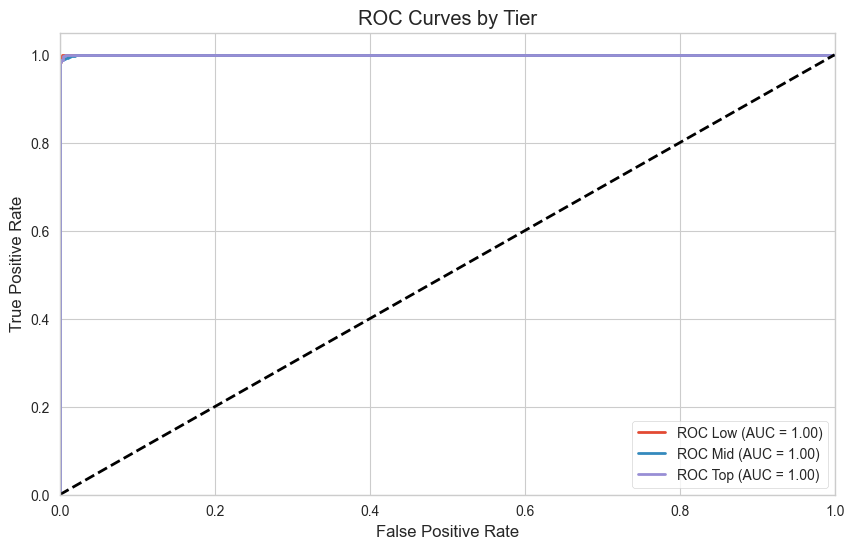


--- Top 10 Ranked Candidates ---


KeyError: "['Predicted_Tier', 'Talent_Score'] not in index"

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             silhouette_score, davies_bouldin_score, roc_curve, auc, roc_auc_score)

# Set visual style
sns.set_style("whitegrid")

# ---------------------------------------------------------
# 1. LOAD & PREPROCESS DATA
# ---------------------------------------------------------
df = pd.read_csv('so_raw.csv')

# Keep metadata
metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

# Select Features
features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location', 'AboutMe', 'WebsiteUrl']
X_raw = df.drop(columns=features_drop, errors='ignore').select_dtypes(include=[np.number])

# Handle NaNs and Infinity
X_raw = X_raw.fillna(0)
X_clean = np.nan_to_num(X_raw, posinf=0, neginf=0)
X_df = pd.DataFrame(X_clean, columns=X_raw.columns)

# Log Transformation (Crucial for Skewed Data)
for col in X_df.columns:
    X_df[col] = np.log1p(np.abs(X_df[col]))

# Scale Data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_df), columns=X_df.columns)

# ---------------------------------------------------------
# 2. UNSUPERVISED: K-MEANS (k=3)
# ---------------------------------------------------------
print("\n--- 1. Running K-Means Clustering (k=3) ---")

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
raw_labels = kmeans.fit_predict(X_scaled)

# Map Random Labels to Logical Ranks (0=Low, 1=Mid, 2=Top) based on Median Reputation
df['Temp_Cluster'] = raw_labels
cluster_quality = df.groupby('Temp_Cluster')['Reputation'].median().sort_values()
rank_map = {old_label: new_rank for new_rank, old_label in enumerate(cluster_quality.index)}
df['Tier_Rank'] = df['Temp_Cluster'].map(rank_map)
df['Tier_Name'] = df['Tier_Rank'].map({0: 'Low Tier', 1: 'Mid Tier', 2: 'Top Tier'})

# --- EVALUATION METRICS: CLUSTERING ---
print("\n--- Clustering Evaluation Metrics ---")
sil_score = silhouette_score(X_scaled, df['Tier_Rank'])
db_score = davies_bouldin_score(X_scaled, df['Tier_Rank'])

print(f"1. Silhouette Score:       {sil_score:.4f} (Closer to 1 is better)")
print(f"2. Davies-Bouldin Index:   {db_score:.4f} (Lower is better)")

# Visualization: Clusters via PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Tier_Name'], palette='viridis', alpha=0.7)
plt.title(f'K-Means Clusters (Silhouette Score: {sil_score:.2f})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# ---------------------------------------------------------
# 3. SUPERVISED: LOGISTIC REGRESSION
# ---------------------------------------------------------
print("\n--- 2. Running Logistic Regression (Supervised) ---")

y = df['Tier_Rank']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# --- EVALUATION METRICS: CLASSIFICATION ---
print("\n--- Classification Evaluation Metrics ---")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Tier', 'Mid Tier', 'Top Tier']))

# ---------------------------------------------------------
# VISUALIZATION: CONFUSION MATRIX & ROC CURVES
# ---------------------------------------------------------

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Mid', 'Top'], yticklabels=['Low', 'Mid', 'Top'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Tier')
plt.xlabel('Predicted Tier')
plt.show()

# 2. ROC-AUC Curves (One-vs-Rest for Multi-Class)
# Binarize the output for ROC calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
tier_labels = {0: 'Low', 1: 'Mid', 2: 'Top'}

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC {tier_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Tier')
plt.legend(loc="lower right")
plt.show()

# ---------------------------------------------------------
# 4. FINAL RANKING & SCORING
# ---------------------------------------------------------
# Calculate full probabilities for final list
final_probs = log_reg.decision_function(X_scaled)
final_df = metadata.copy()
final_df['Predicted_Tier'] = log_reg.predict(X_scaled)
# Score = Probability of being Top Tier (Class 2) * 100
final_df['Talent_Score'] = final_probs[:, 2] * 100


print("\n--- Top 10 Ranked Candidates ---")

formatted = ranked_candidates[['user_id', 'DisplayName', 'Reputation',
                               'Predicted_Tier', 'Talent_Score']].head(10).copy()

formatted['Talent_Score'] = formatted['Talent_Score'].map(lambda x: f"{x:011.50f}")

print(formatted)



--- Applying Quantile Scaling (Preprocessing) ---
--- Applying PCA (2 Components) ---

--- Running K-Means Clustering (k=2) ---
Silhouette Score: 0.4737
Davies-Bouldin:   0.9326


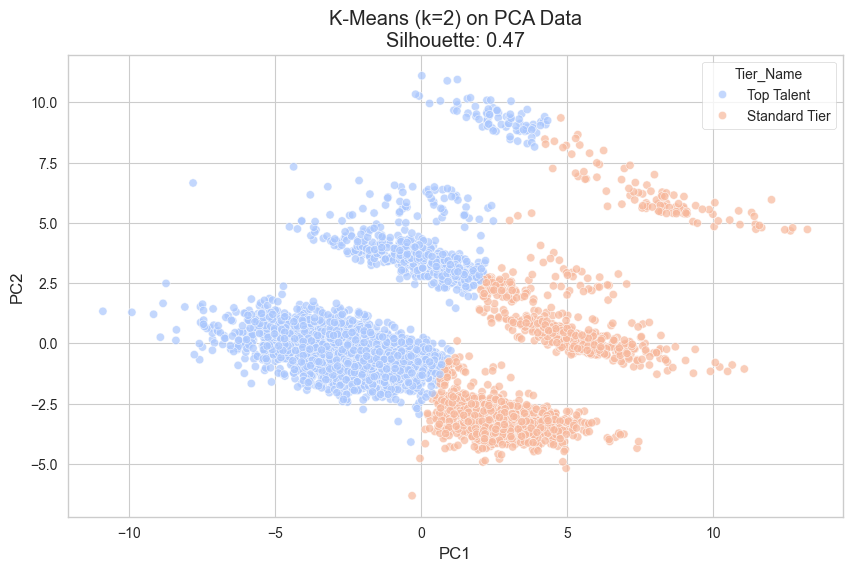


--- Running Logistic Regression (Binary) ---
Accuracy: 0.9980

Classification Report:
              precision    recall  f1-score   support

    Standard       1.00      1.00      1.00       308
  Top Talent       1.00      1.00      1.00       692

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



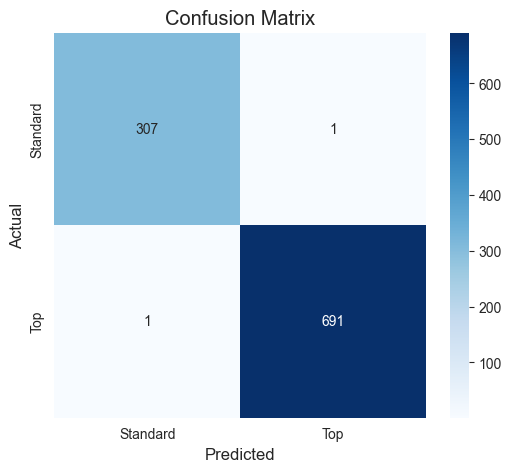

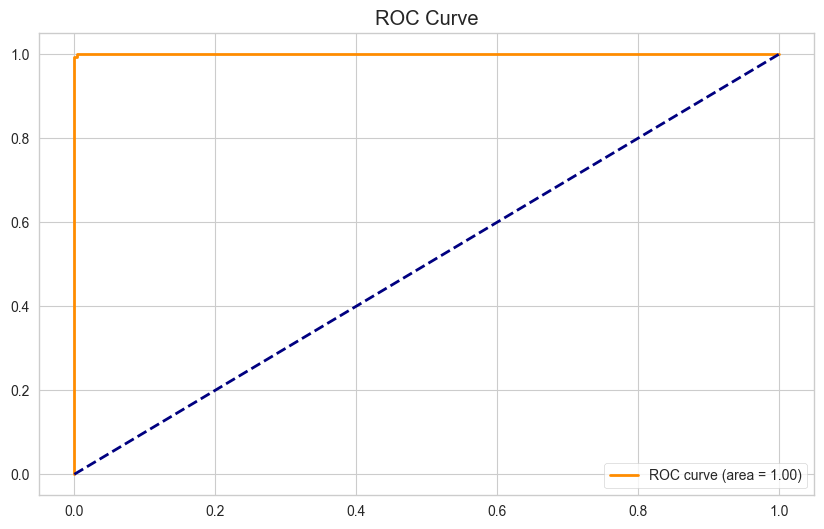


--- Top 10 Ranked Candidates (SOTS Scaled 0-100) ---
 user_id      DisplayName  Reputation Cluster_Label                     SOTS
   22656        Jon Skeet     1523453    Top Talent 100.00000000000000000000
    6309             VonC     1365445    Top Talent  99.94788017984326700116
   17034     Hans Passant      946973    Top Talent  99.94365757082070444994
 1144035    Gordon Linoff     1276212    Top Talent  99.91076157335756136035
  157882           BalusC     1115076    Top Talent  99.90795007506514480156
  100297  Martijn Pieters     1139881    Top Talent  99.89998983310809421710
  115145      CommonsWare     1011523    Top Talent  99.86735308914164477301
 3832970 Wiktor Stribiżew      631314    Top Talent  99.83980784259456697782
   23354     Marc Gravell     1071509    Top Talent  99.83468105398485192836
  157247     T.J. Crowder     1082564    Top Talent  99.82366686553984891361


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             silhouette_score, davies_bouldin_score, roc_curve, auc)

# Set visual style
sns.set_style("whitegrid")

# ---------------------------------------------------------
# 1. LOAD & PREPROCESS DATA
# ---------------------------------------------------------
try:
    df = pd.read_csv('so_raw.csv')
except FileNotFoundError:
    print("File not found. Please ensure 'so_raw.csv' is in the working directory.")
    # Dummy data generation
    np.random.seed(42)
    data = {
        'user_id': range(1, 1001),
        'DisplayName': [f'User_{i}' for i in range(1, 1001)],
        'Reputation': np.concatenate([np.random.exponential(500, 800), np.random.exponential(10000, 200)]),
        'up_votes_given_by_user': np.random.randint(0, 500, 1000),
        'profile_views': np.random.randint(0, 10000, 1000),
        'total_answer_score': np.random.normal(50, 20, 1000)
    }
    df = pd.DataFrame(data)

metadata = df[['user_id', 'DisplayName', 'Reputation']].copy()

features_drop = ['user_id', 'DisplayName', 'CreationDate', 'LastAccessDate', 'Location', 'AboutMe', 'WebsiteUrl']
X_raw = df.drop(columns=features_drop, errors='ignore').select_dtypes(include=[np.number])

# Handle NaNs
X_raw = X_raw.fillna(0)
X_clean = np.nan_to_num(X_raw, posinf=0, neginf=0)
X_df = pd.DataFrame(X_clean, columns=X_raw.columns)

# --- PREPROCESSING SCALER ---
print("\n--- Applying Quantile Scaling (Preprocessing) ---")
# Using Normal distribution here to help PCA/KMeans
qt_pre = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = pd.DataFrame(qt_pre.fit_transform(X_df), columns=X_df.columns)

# --- APPLY PCA ---
print("--- Applying PCA (2 Components) ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# ---------------------------------------------------------
# 2. UNSUPERVISED: K-MEANS (k=2)
# ---------------------------------------------------------
print("\n--- Running K-Means Clustering (k=2) ---")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
raw_labels = kmeans.fit_predict(X_pca_df)

# Map Labels
df['Temp_Cluster'] = raw_labels
cluster_quality = df.groupby('Temp_Cluster')['Reputation'].median().sort_values()
rank_map = {old_label: new_rank for new_rank, old_label in enumerate(cluster_quality.index)}

df['Tier_Rank'] = df['Temp_Cluster'].map(rank_map)
df['Tier_Name'] = df['Tier_Rank'].map({0: 'Standard Tier', 1: 'Top Talent'})

# --- METRICS ---
sil_score = silhouette_score(X_pca_df, df['Tier_Rank'])
db_score = davies_bouldin_score(X_pca_df, df['Tier_Rank'])
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin:   {db_score:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=df['Tier_Name'], data=X_pca_df.join(df['Tier_Name']), palette='coolwarm', alpha=0.7)
plt.title(f'K-Means (k=2) on PCA Data\nSilhouette: {sil_score:.2f}')
plt.show()

# ---------------------------------------------------------
# 3. SUPERVISED: LOGISTIC REGRESSION
# ---------------------------------------------------------
print("\n--- Running Logistic Regression (Binary) ---")

y = df['Tier_Rank']
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# --- METRICS ---
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Standard', 'Top Talent']))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Standard', 'Top'], yticklabels=['Standard', 'Top'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# ---------------------------------------------------------
# 4. FINAL SCORING: SOTS (Quantile Scaled)
# ---------------------------------------------------------
# 1. Get raw Probabilities
final_probs = log_reg.decision_function(X_pca_df)

final_df = metadata.copy()
final_df['Cluster_Label'] = df['Tier_Name']

# 2. Apply QuantileTransformer (Uniform)
# This forces the scores to spread out evenly between 0 and 1 (Percentile Rank),
# creating distinct values even if raw probabilities are clumped.
n_q = min(len(final_df), 1000) # Ensure n_quantiles isn't larger than dataset
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=n_q, random_state=42)

# Transform to 0-1, then multiply by 100 for SOTS
final_df['SOTS'] = scaler.fit_transform(final_probs.reshape(-1, 1)) * 100

# 3. Sort
ranked_candidates = final_df.sort_values(by='SOTS', ascending=False)

print("\n--- Top 10 Ranked Candidates (SOTS Scaled 0-100) ---")
# 4. Print with 20 decimals
print(ranked_candidates[['user_id', 'DisplayName', 'Reputation', 'Cluster_Label', 'SOTS']]
      .head(10)
      .to_string(index=False, formatters={'SOTS': '{:.20f}'.format}))

In [65]:
df_fff = pd.concat([ranked_candidates,df], axis=1)
df_fff.head(10)
df_fff.to_csv("SOFinalFinal.csv", index=False)